In [19]:
import os
from collections import defaultdict
import pandas as pd
import pydicom
from prepro_script import *  # Imports all functions from prepro_script.py
import numpy as np



os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [20]:
# import os

# data_path_img = "C:/Users/alime/Dropbox (AMC)/Mon PC (DESKTOP-RG9FHVT)/Desktop/Deauville/Deauville_DeepLearning/images"

# print("✅ Listing first 10 files in dataset folder:")
# print(os.listdir(data_path_img)[:10])  # Show first 10 files



In [21]:
# ---------------------------
# 1. Loading the PET Series
# ---------------------------
def load_pet_series(modality_path):
    """
    Load all PET DICOM files from a modality folder, group them by SeriesInstanceUID,
    sort by InstanceNumber, and stack them into a 3D NumPy array.
    
    Parameters:
      modality_path (str): Path to the PET DICOM folder.
    
    Returns:
      dict: Mapping from series UID to a dict containing:
            - 'volume': 3D NumPy array (unsorted raw pixel data)
            - 'metadata': A representative DICOM dataset (from the first slice)
    """
    
    series_dict = defaultdict(list)
    # We now keep the entire list of DICOM slices for each series.
    if not os.path.exists(modality_path):
        print(f"❌ ERROR: Folder '{modality_path}' does not exist!")
        return {}
    
    files = os.listdir(modality_path)
    for file in files:
        file_path = os.path.join(modality_path, file)
        if os.path.isfile(file_path):
            try:
                ds = pydicom.dcmread(file_path)
                # Extract SeriesInstanceUID
                series_id = ds.get("SeriesInstanceUID", None)
                if series_id is None:
                    continue
                series_dict[series_id].append(ds)
            except Exception as e:
                print(f"❌ ERROR reading {file_path}: {e}")
    
    # Convert series_dict to stacked NumPy arrays and store full list of slices
    series_volumes = {}
    for series_id, ds_list in series_dict.items():
        ds_list.sort(key=lambda s: int(s.get("InstanceNumber", 0)))
        try:
            volume = np.stack([s.pixel_array for s in ds_list])
            series_volumes[series_id] = {"volume": volume, "metadata_list": ds_list}
        except Exception as e:
            print(f"❌ ERROR stacking slices for series {series_id}: {e}")
    return series_volumes

In [22]:
# ---------------------------
# 2. Loading PET Study Data from a Study Folder
# ---------------------------
def load_pet_study(study_path, modality_name="QClear 550_DICOM"):
    """
    Load the PET series from a study folder by looking for a subfolder with the given modality name.
    
    Parameters:
        study_path (str): Path to the study folder.
        modality_name (str): The name of the PET modality folder (default: "QClear 550_DICOM").
    
    Returns:
        dict: Mapping from series UID to PET series data if the modality folder exists;
              otherwise, an empty dict.
    """
    modality_folder = os.path.join(study_path, modality_name)
    if os.path.isdir(modality_folder):
        print(f"Found modality folder: {modality_folder}")
        return load_pet_series(modality_folder)
    else:
        print(f"Modality folder '{modality_name}' not found in {study_path}")
        return {}

In [23]:
# ---------------------------
# 3. Loading Patient Data: Traverse Studies and PET Series
# ---------------------------
def load_patient_data(patient_path):
    """
    Load all studies and their respective PET series for a given patient.
    
    Parameters:
        patient_path (str): Path to the patient folder (e.g., '.../00000105').
    
    Returns:
        dict: Nested dictionary where keys are study folder names and values are the output of load_pet_study.
    """
    patient_data = {}
    for study in os.listdir(patient_path):
        study_path = os.path.join(patient_path, study)
        if os.path.isdir(study_path):
            print(f"Processing study folder: {study_path}")
            study_pet_data = load_pet_study(study_path)
            if study_pet_data:  # Only add if PET data is found
                patient_data[study] = study_pet_data
    return patient_data


In [24]:
# 2. Loading All Patients Data from a Directory
# ---------------------------
def load_all_patients_data(data_dir):
    """
    Load the PET data for all patients in a given directory.
    
    Parameters:
        data_dir (str): Directory containing patient folders.
        
    Returns:
        dict: A dictionary where keys are patient IDs (folder names) and values are the output of load_patient_data.
    """
    all_patient_data = {}
    for patient_folder in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_folder)
        if os.path.isdir(patient_path):
            print(f"Loading data for patient: {patient_folder}")
            patient_data = load_patient_data(patient_path)
            if patient_data:
                all_patient_data[patient_folder] = patient_data
    return all_patient_data

In [25]:
def split_patients(all_patient_data, test_ratio=0.0):
    """
    Split the patients at the patient level into a training/tuning set and a held-out test set.
    
    Parameters:
        all_patient_data (dict): Output from load_all_patients_data.
        test_ratio (float): Proportion of patients to use for the test set.
        
    Returns:
        tuple: (train_tune_data, test_data) where each is a dict of patient data.
    """
    patient_ids = list(all_patient_data.keys())
    random.shuffle(patient_ids)
    num_test = int(len(patient_ids) * test_ratio)
    test_ids = patient_ids[:num_test]
    train_tune_ids = patient_ids[num_test:]
    
    train_tune_data = {pid: all_patient_data[pid] for pid in train_tune_ids}
    test_data = {pid: all_patient_data[pid] for pid in test_ids}
    
    print(f"Total patients: {len(patient_ids)}; Training/Tuning: {len(train_tune_ids)}; Test: {len(test_ids)}")
    return train_tune_data, test_data


Now that we have 2 images (MIP) per patient, new script encore a tester ! 

In [26]:
import os
import random
import numpy as np
import pandas as pd

# --- SETTINGS ---
data_dir = r"/home/mezher/Documents/Deauville_DeepLearning/PET"
modality_name = "QClear 550_DICOM"  # Name of the PET modality folder
num_splits = 20  # Number of bootstrap splits

# Create a manual target mapping.
manual_target_map = {
    "PatientA": 0,
    "PatientB": 0,
    "PatientC": 1,
    "PatientD": 0,
    "PatientE": 0,
    "PatientF": 0,
    "PatientG": 1,
    "PatientH": 1,
    "PatientI": 1,
    "PatientJ": 1,
    "PatientK": 1,
    "PatientL": 0,
    "PatientM": 0,
    "PatientN": 0,
}

# -----------------------------------------------------------
# 1. Load All Patients Data & Split into Train/Tuning and Test
# -----------------------------------------------------------
# (Assuming load_all_patients_data and split_patients are defined elsewhere.)
all_patient_data = load_all_patients_data(data_dir)
train_tune_data, test_data = split_patients(all_patient_data, test_ratio=1.0)

# ---------------------------
# 2. Load and Preprocess Patients Data
# ---------------------------
all_scan_list = []
global_scan_id = 0

# Process training/tuning patients
for patient_id, patient_data in train_tune_data.items():
    if patient_id not in manual_target_map:
        print(f"Error: No target label defined for patient {patient_id}. Skipping this patient.")
        continue  # Skip processing this patient
    target = manual_target_map[patient_id]
    print(f"Processing training/tuning patient: {patient_id} with target {target}")
    
    preprocessed_data = {}
    for study, series in patient_data.items():
        preprocessed_data[study] = {}
        for series_uid, data in series.items():
            # Apply preprocessing pipeline on this PET series (returns two MIPs)
            processed_images = preprocess_pet_series(data)
            mip_coronal = processed_images["mip_coronal"]
            mip_sagittal = processed_images["mip_sagittal"]
            suv_volume = processed_images["suv_volume"]

            preprocessed_data[study][series_uid] = {
                "mip_coronal": mip_coronal,
                "mip_sagittal": mip_sagittal,
                "suv_volume": suv_volume
            }

    # For training/tuning, assign a random bootstrap split (train/val)
    bootstrap_splits = {}
    for split in range(num_splits):
        label = "train" if random.random() < 0.8 else "val"
        bootstrap_splits[f"split{split}"] = label

    # Process preprocessed images and add them to the CSV
    for study, series_dict in preprocessed_data.items():
        for series_uid, data in series_dict.items():
            # Define filenames for the two MIP views.
            filename_coronal = f"{patient_id}_cor.npy"
            filename_sagittal = f"{patient_id}_sag.npy"

            # Define storage paths.
            image_dir = os.path.join(os.getcwd(), "images")
            os.makedirs(image_dir, exist_ok=True)
            image_path_coronal = os.path.join(image_dir, filename_coronal)
            image_path_sagittal = os.path.join(image_dir, filename_sagittal)

            # Save both MIP images.
            np.save(image_path_coronal, data["mip_coronal"].astype(np.float32))
            np.save(image_path_sagittal, data["mip_sagittal"].astype(np.float32))

            # Create two CSV rows (one per view) with the same scan_id and target.
            for mip_view, filename, matrix_size in zip(
                ["coronal", "sagittal"],
                [filename_coronal, filename_sagittal],
                [(data["mip_coronal"].shape[0], data["mip_coronal"].shape[1]),
                 (data["mip_sagittal"].shape[0], data["mip_sagittal"].shape[1])]
            ):
                row = {
                    "patient_id": patient_id,
                    "scan_id": global_scan_id,
                    "filename": os.path.join("images", filename),
                    "target": target,
                    "matrix_size_1": matrix_size[0],
                    "matrix_size_2": matrix_size[1]
                }
                for split_key, label in bootstrap_splits.items():
                    row[split_key] = label
                all_scan_list.append(row)

            global_scan_id += 1

# Process test patients
for patient_id, patient_data in test_data.items():
    if patient_id not in manual_target_map:
        print(f"Error: No target label defined for patient {patient_id}. Skipping this patient.")
        continue  # Skip processing this patient
    target = manual_target_map[patient_id]
    print(f"Processing test patient: {patient_id} with target {target}")
    
    preprocessed_data = {}
    for study, series in patient_data.items():
        preprocessed_data[study] = {}
        for series_uid, data in series.items():
            # Apply preprocessing pipeline on this PET series (returns two MIPs)
            processed_images = preprocess_pet_series(data)
            mip_coronal = processed_images["mip_coronal"]
            mip_sagittal = processed_images["mip_sagittal"]
            suv_volume = processed_images["suv_volume"]

            preprocessed_data[study][series_uid] = {
                "mip_coronal": mip_coronal,
                "mip_sagittal": mip_sagittal,
                "suv_volume": suv_volume
            }

    # For test patients, assign all splits to "test"
    bootstrap_splits = {f"split{split}": "test" for split in range(num_splits)}

    # Process preprocessed images and add them to the CSV
    for study, series_dict in preprocessed_data.items():
        for series_uid, data in series_dict.items():
            # Define filenames for the two MIP views.
            filename_coronal = f"{patient_id}_cor.npy"
            filename_sagittal = f"{patient_id}_sag.npy"

            # Define storage paths.
            image_dir = os.path.join(os.getcwd(), "images")
            os.makedirs(image_dir, exist_ok=True)
            image_path_coronal = os.path.join(image_dir, filename_coronal)
            image_path_sagittal = os.path.join(image_dir, filename_sagittal)

            # Save both MIP images.
            np.save(image_path_coronal, data["mip_coronal"].astype(np.float32))
            np.save(image_path_sagittal, data["mip_sagittal"].astype(np.float32))

            # Create two CSV rows (one per view) with the same scan_id and target.
            for mip_view, filename, matrix_size in zip(
                ["coronal", "sagittal"],
                [filename_coronal, filename_sagittal],
                [(data["mip_coronal"].shape[0], data["mip_coronal"].shape[1]),
                 (data["mip_sagittal"].shape[0], data["mip_sagittal"].shape[1])]
            ):
                row = {
                    "patient_id": patient_id,
                    "scan_id": global_scan_id,
                    "filename": os.path.join("images", filename),
                    "target": target,
                    "matrix_size_1": matrix_size[0],
                    "matrix_size_2": matrix_size[1]
                }
                for split_key, label in bootstrap_splits.items():
                    row[split_key] = label
                all_scan_list.append(row)

            global_scan_id += 1

# -----------------------------------------------------------
# 3. Create DataFrame and Save CSV
# -----------------------------------------------------------
df = pd.DataFrame(all_scan_list)
print(df.head())
df.to_csv("data.csv", index=False)


Loading data for patient: PatientD
Processing study folder: /home/mezher/Documents/Deauville_DeepLearning/PET/PatientD/2024-11__Studies
Found modality folder: /home/mezher/Documents/Deauville_DeepLearning/PET/PatientD/2024-11__Studies/QClear 550_DICOM
Loading data for patient: PatientC
Processing study folder: /home/mezher/Documents/Deauville_DeepLearning/PET/PatientC/2024-10__Studies
Found modality folder: /home/mezher/Documents/Deauville_DeepLearning/PET/PatientC/2024-10__Studies/QClear 550_DICOM
Loading data for patient: PatientG
Processing study folder: /home/mezher/Documents/Deauville_DeepLearning/PET/PatientG/Study
Found modality folder: /home/mezher/Documents/Deauville_DeepLearning/PET/PatientG/Study/QClear 550_DICOM
Loading data for patient: PatientJ
Processing study folder: /home/mezher/Documents/Deauville_DeepLearning/PET/PatientJ/2020-02__Studies
Found modality folder: /home/mezher/Documents/Deauville_DeepLearning/PET/PatientJ/2020-02__Studies/QClear 550_DICOM
Loading data f

Since le splitting se fait patient wise ici et que les nombre de scan par patient sont pas égaux, ca entraine un splitting qui est pas de 80/20 au niveau du nombre de scan.

Found image files: ['PatientE_cor.npy', 'PatientF_sag.npy', 'PatientB_sag.npy', 'PatientM_sag.npy', 'PatientF_cor.npy', 'PatientC_cor.npy', 'PatientB_cor.npy', 'PatientH_sag.npy', 'PatientI_sag.npy', 'PatientM_cor.npy', 'PatientC_sag.npy', 'PatientL_sag.npy', 'PatientA_cor.npy', 'PatientD_sag.npy', 'PatientJ_cor.npy', 'PatientH_cor.npy', 'PatientG_sag.npy', 'PatientG_cor.npy', 'PatientL_cor.npy', 'PatientA_sag.npy', 'PatientN_sag.npy', 'PatientJ_sag.npy', 'PatientK_sag.npy', 'PatientK_cor.npy', 'PatientE_sag.npy', 'PatientN_cor.npy', 'PatientD_cor.npy', 'PatientI_cor.npy']
Selected files: ['PatientE_cor.npy', 'PatientM_cor.npy', 'PatientB_sag.npy', 'PatientE_sag.npy', 'PatientM_sag.npy', 'PatientG_sag.npy', 'PatientC_cor.npy', 'PatientF_cor.npy', 'PatientL_cor.npy', 'PatientB_cor.npy', 'PatientJ_cor.npy', 'PatientI_cor.npy', 'PatientN_sag.npy', 'PatientH_sag.npy', 'PatientL_sag.npy', 'PatientD_sag.npy', 'PatientA_sag.npy', 'PatientA_cor.npy', 'PatientJ_sag.npy', 'PatientF_sag.npy']


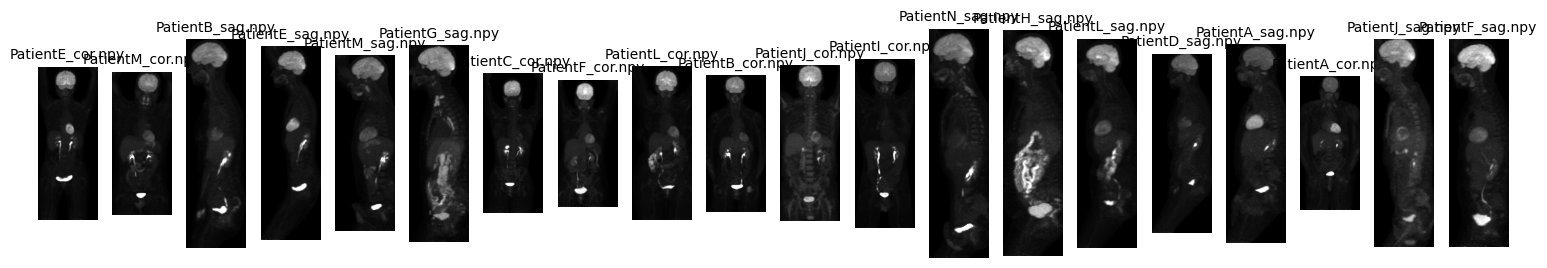

In [27]:
# Define the images folder (adjust if necessary)
images_dir = os.path.join(os.getcwd(), "images")

# List all .npy files in the folder
image_files = [f for f in os.listdir(images_dir) if f.endswith('.npy')]
print("Found image files:", image_files)

# Randomly select 5 images (if there are fewer than 5, select all)
selected_files = random.sample(image_files, min(20, len(image_files)))
print("Selected files:", selected_files)

# Plot the selected images in a row
fig, axes = plt.subplots(1, len(selected_files), figsize=(15, 5))
for ax, file in zip(axes, selected_files):
    img = np.load(os.path.join(images_dir, file))
    ax.imshow(img, cmap='gray')
    ax.set_title(file, fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()